In [2]:
import torch
from d2l import torch as d2l
import os
import math
import random
import collections

# 读取数据集
### 我们在这里使用的数据集是Penn Tree Bank（PTB）。该语料库取自“华尔街日报”的文章，分为训练集、验证集和测试集。在原始格式中，文本文件的每一行表示由空格分隔的一句话。在这里，我们将每个单词视为一个词元。

In [10]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')] 

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

In [27]:
vocab = d2l.Vocab(sentences, min_freq = 10)
f'vocab size: {len(vocab)}'
f'{vocab.unk}'

'26'

# 下采样
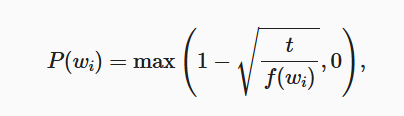


In [34]:
def subsample(sentences, vocab):
    # 下采样高频词
    # 排除未知词元 '<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([token for line in sentences for token in line]) # 将所有句子中的词平铺到一个单一的列表中，然后计算每个词出现的次数
    print(counter.most_common(5))
    num_tokens = sum(counter.values())
    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return (random.uniform(0, 1) <
                math.sqrt(1e-4 / counter[token] * num_tokens))
    return ([[token for token in line if keep(token)] for line in sentences], counter)

subsampled, counter = subsample(sentences, vocab)

[('the', 50770), ('N', 32481), ('of', 24400), ('to', 23638), ('a', 21196)]


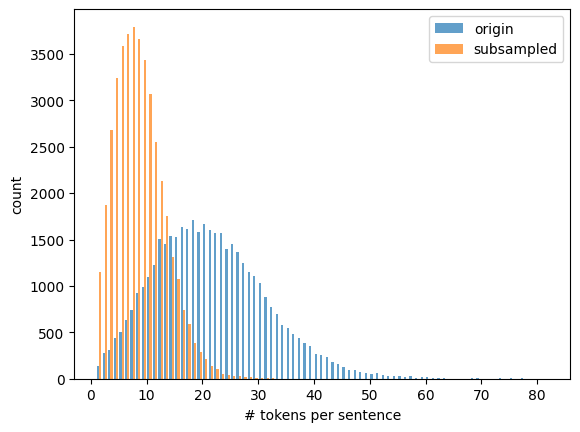

In [7]:
import matplotlib.pyplot as plt

def show_list_len_pair_hist(labels, xlabel, ylabel, data1, data2):
    # 计算每个句子的长度
    len_data1 = [len(sentence) for sentence in data1]
    len_data2 = [len(sentence) for sentence in data2]

    # 绘制直方图
    plt.hist([len_data1, len_data2], label=labels, bins=range(1, max(len_data1 + len_data2) + 1), alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# 示例使用
show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence', 'count', sentences, subsampled)

In [8]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([line.count(token) for line in sentences])}, '
            f'after={sum([line.count(token) for line in subsampled])}')

print(compare_counts('the'))
print(compare_counts('join'))

# of "the": before=50770, after=2016
# of "join": before=45, after=45


In [9]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[], [6697, 4127, 3228, 1773], [3178, 3922, 1922, 4743]]

##### 中心词和上下文的提取

In [10]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # 要形成上下文，每个句子至少需要2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), min(len(line), i + 1 + window_size)))
            # 删除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [11]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2]
center 2 has contexts [1, 3]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [12]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

'# “中心词-上下文词对”的数量: 1500586'

In [13]:
#@save
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]
    
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 2, 3, 3, 1, 2, 2, 1, 3, 3]

对于一对中心词和上下文词，我们随机抽取了K个（实验中为5个）噪声词。根据word2vec论文中的建议，将噪声词的采样概率设置为其在字典中的相对频率，其幂为0.75 (Mikolov et al., 2013)。

In [14]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

小批量加载训练实例
在提取所有中心词及其上下文词和采样噪声词后，将它们转换成小批量的样本，在训练过程中可以迭代加载。

在小批量中，
个样本包括中心词及其
个上下文词和
个噪声词。由于上下文窗口大小不同，
对于不同的
是不同的。因此，对于每个样本，我们在contexts_negatives个变量中将其上下文词和噪声词连结起来，并填充零，直到连结长度达到
(max_len)。为了在计算损失时排除填充，我们定义了掩码变量masks。在masks中的元素和contexts_negatives中的元素之间存在一一对应关系，其中masks中的0（否则为1）对应于contexts_negatives中的填充。

为了区分正反例，我们在contexts_negatives中通过一个labels变量将上下文词与噪声词分开。类似于masks，在labels中的元素和contexts_negatives中的元素之间也存在一一对应关系，其中labels中的1（否则为0）对应于contexts_negatives中的上下文词的正例。

上述思想在下面的batchify函数中实现。其输入data是长度等于批量大小的列表，其中每个元素是由中心词center、其上下文词context和其噪声词negative组成的样本。此函数返回一个可以在训练期间加载用于计算的小批量，例如包括掩码变量。

In [15]:
#@save
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))] # 1 for context, 0 for negative
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [16]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


#### 整合代码
最后，我们定义了读取PTB数据集并返回数据迭代器和词表的load_data_ptb函数。

In [22]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    num_workers = 0
    sentences = read_ptb() # 返回所有的句子里面 同时里面的单词
    vocab = d2l.Vocab(sentences, min_freq = 10) # 其中每个唯一的词汇（token）会映射到一个整数索引
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

In [23]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])
